In [10]:
from math import *
from networkx import *
import random
from copy import deepcopy
import os, sys
import time
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import curve_fit
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from p_tqdm import p_map
from natsort import natsorted
import numpy as np
from multiprocessing import Pool
import collections
import powerlaw
import community as cm

In [11]:
def fractal_model(generation,m,x,e):
	"""
	Returns the fractal model introduced by
	Song, Havlin, Makse in Nature Physics 2, 275.
	generation = number of generations
	m = number of offspring per node
	x = number of connections between offsprings
	e = probability that hubs stay connected
	1-e = probability that x offsprings connect.
	If e=1 we are in MODE 1 (pure small-world).
	If e=0 we are in MODE 2 (pure fractal).
	"""
	G=Graph()
	G.add_edge(0,1) #This is the seed for the network (generation 0)
	node_index = 2
	for n in range(1,generation+1):
		all_links = list(G.edges())
		while all_links:
			link = all_links.pop()
			new_nodes_a = range(node_index,node_index + m)
			#random.shuffle(new_nodes_a)
			node_index += m
			new_nodes_b = range(node_index,node_index + m)
			#random.shuffle(new_nodes_b)
			node_index += m
			G.add_edges_from([(link[0],node) for node in new_nodes_a])
			G.add_edges_from([(link[1],node) for node in new_nodes_b])
			repulsive_links = list(zip(new_nodes_a,new_nodes_b))
			G.add_edges_from([repulsive_links.pop() for i in range(x-1)])
			if random.random() > e:
				G.remove_edge(link[0], link[1])
				new_edge = repulsive_links.pop()
				G.add_edge(new_edge[0], new_edge[1])
	return G

In [12]:
def MEMB(G,rb,cycle=0):
	"""
	It returns a dictionary with {box_id:subgraph_generated_by_the_nodes_in_this_box}
	The box_id is the center of the box.
	cycle: Ignore this parameter. Use the default cycle=0.
	"""
	adj = G.adj
	number_of_nodes = G.number_of_nodes()
	covered_nodes = set()
	center_nodes = set()
	non_center_nodes = G.nodes()
	center_node_found = 0
	boxes={} #this will be "box_id:[nodes in box]"
	central_distance_of_node = {} #"node:central_distance"
	node_box_id = {} #"node:box_id"
	nodes_sorted_by_central_distance={} #Dict with {central_distance:[nodes]}
	excluded_mass_of_non_centers_rb = {} #This contains [(node:excluded_mass)] for rb
	excluded_mass_of_non_centers_rb2 = {} #This contains [(node:excluded_mass)] for rb+1
	rb2 = rb + 1
	for node in non_center_nodes:
		#if node in [5000,10000,20000,30000]: print "node", node
		level=0                  # the current level
		nextlevel={node:1}       # list of nodes to check at next level
		paths_rb=None
		paths_rb2={node:[node]} # paths dictionary  (paths to key from source)
		while nextlevel:
			paths_rb = deepcopy(paths_rb2)
			thislevel=nextlevel
			nextlevel={}
			for v in thislevel:
				for w in G.neighbors(v):
					if not w in paths_rb2:
						paths_rb2[w]=paths_rb2[v]+[w]
						nextlevel[w]=1
			level=level+1
			if (rb2 <= level):  break
		excluded_mass_of_node = len(paths_rb2)
		try:
			excluded_mass_of_non_centers_rb2[excluded_mass_of_node].append(node)
		except KeyError:
			excluded_mass_of_non_centers_rb2[excluded_mass_of_node] = [node]
		excluded_mass_of_node = len(paths_rb)
		try:
			excluded_mass_of_non_centers_rb[excluded_mass_of_node].append(node)
		except KeyError:
			excluded_mass_of_non_centers_rb[excluded_mass_of_node] = [node]
	maximum_excluded_mass = 0
	nodes_with_maximum_excluded_mass=[]
	new_covered_nodes = {}
	center_node_and_mass = []
	cycle_index = 0
	while len(covered_nodes) < number_of_nodes:
		#print len(covered_nodes),number_of_nodes
		cycle_index += 1
		if cycle_index == cycle:
			rb2 = rb+1
			cycle_index = 0
		else:
			rb2 = rb
		while 1:
			if rb2 == rb+1:
				#t1=time.time()
				while 1:
					maximum_key = max(excluded_mass_of_non_centers_rb2.keys())
					node = random.choice(excluded_mass_of_non_centers_rb2[maximum_key])
					if node in center_nodes:
						excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
						if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					else:
						break
				nodes_visited = {}
				bfs = single_source_shortest_path(G,node,cutoff=rb2)
				for i in bfs:
					nodes_visited[i] = len(bfs[i])-1
				excluded_mass_of_node = len(set(nodes_visited.keys()).difference(covered_nodes))
				if excluded_mass_of_node == maximum_key:
					center_node_and_mass = (node,maximum_key)
					excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					new_covered_nodes = nodes_visited
					break
				else:
					excluded_mass_of_non_centers_rb2[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb2[maximum_key]: del excluded_mass_of_non_centers_rb2[maximum_key]
					try:
						excluded_mass_of_non_centers_rb2[excluded_mass_of_node].append(node)
					except KeyError:
						excluded_mass_of_non_centers_rb2[excluded_mass_of_node] = [node]
				#print "time", time.time()-t1
			else:
				#t1=time.time()
				while 1:
					maximum_key = max(excluded_mass_of_non_centers_rb.keys())
					node = random.choice(excluded_mass_of_non_centers_rb[maximum_key])
					if node in center_nodes:
						excluded_mass_of_non_centers_rb[maximum_key].remove(node)
						if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					else:
						break
				nodes_visited = {}
				bfs = single_source_shortest_path(G,node,cutoff=rb)
				for i in bfs:
					nodes_visited[i] = len(bfs[i])-1
				excluded_mass_of_node = len(set(nodes_visited.keys()).difference(covered_nodes))
				if excluded_mass_of_node == maximum_key:
					center_node_and_mass = (node,maximum_key)
					excluded_mass_of_non_centers_rb[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					new_covered_nodes = nodes_visited
					break
				else:
					excluded_mass_of_non_centers_rb[maximum_key].remove(node)
					if not excluded_mass_of_non_centers_rb[maximum_key]: del excluded_mass_of_non_centers_rb[maximum_key]
					try:
						excluded_mass_of_non_centers_rb[excluded_mass_of_node].append(node)
					except KeyError:
						excluded_mass_of_non_centers_rb[excluded_mass_of_node] = [node]
				#print "time", time.time()-t1

		center_node_found = center_node_and_mass[0]
		boxes[center_node_found] = [center_node_found]
		node_box_id[center_node_found] = center_node_found
		non_center_nodes = list(non_center_nodes)
		non_center_nodes.remove(center_node_found)
		center_nodes.add(center_node_found)

		covered_nodes = covered_nodes.union(set(new_covered_nodes.keys()))
		#print len(covered_nodes)
		for i in new_covered_nodes:

			try:
				if central_distance_of_node[i] > new_covered_nodes[i]:
					nodes_sorted_by_central_distance[central_distance_of_node[i]].remove(i)
					if not nodes_sorted_by_central_distance[central_distance_of_node[i]]:
						del nodes_sorted_by_central_distance[central_distance_of_node[i]]
					try:
						nodes_sorted_by_central_distance[new_covered_nodes[i]].append(i)
					except KeyError:
						nodes_sorted_by_central_distance[new_covered_nodes[i]] = [i]
					central_distance_of_node[i] = new_covered_nodes[i]
			except KeyError:
				central_distance_of_node[i] = new_covered_nodes[i]
				try:
					nodes_sorted_by_central_distance[new_covered_nodes[i]].append(i)
				except:
					nodes_sorted_by_central_distance[new_covered_nodes[i]] = [i]

	max_distance = max(nodes_sorted_by_central_distance.keys())
	for i in range(1,max_distance+1):
		for j in nodes_sorted_by_central_distance[i]:
			targets = list(set(list(adj[j])).intersection(set(nodes_sorted_by_central_distance[i-1])))
			node_box_id[j] = node_box_id[random.choice(targets)]
			boxes[node_box_id[j]].append(j)
	boxes_subgraphs={}
	for i in boxes:
		boxes_subgraphs[i] = subgraph(G,boxes[i])

	return boxes_subgraphs

In [39]:
# g = nx.read_gml('power.gml', label='id')
# g = nx.read_graphml('time_graphs/0/2000.graphml')
# g = nx.read_graphml('0.graphml')
# g = nx.read_edgelist('real_graphs/facebook_combined.txt')
g = fractal_model(3,5,2,0)
print(len(list(nx.connected_components(g))))
print(g.number_of_nodes(), g.number_of_edges())

1
1572 1728


In [40]:
print(nx.diameter(g))

53


In [41]:
max_l = 16

In [42]:
avgs = []
subgraphs = []

for l in tqdm_notebook(range(max_l)):
    boxes_subgraphs = MEMB(g,l)
    print(l, len(boxes_subgraphs), sum([g.number_of_nodes() for g in boxes_subgraphs.values()]) / len(boxes_subgraphs))
    avgs.append(len(boxes_subgraphs))
    subgraphs.append(boxes_subgraphs)

0 1572 1.0
1 132 11.909090909090908
2 132 11.909090909090908
3 108 14.555555555555555
4 12 131.0
5 12 131.0
6 14 112.28571428571429
7 12 131.0
8 12 131.0
9 10 157.2
10 10 157.2
11 10 157.2
12 9 174.66666666666666
13 2 786.0
14 2 786.0
15 2 786.0
16 2 786.0
17 2 786.0
18 3 524.0
19 3 524.0



[1.         0.08396947 0.08396947 0.06870229 0.00763359 0.00763359
 0.00890585 0.00763359 0.00763359 0.00636132 0.00636132 0.00636132
 0.00572519 0.00127226 0.00127226 0.00127226 0.00127226 0.00127226
 0.0019084  0.0019084 ]
[3.04496109]


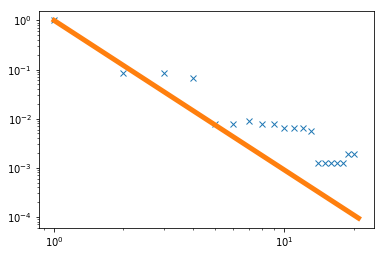

In [51]:
# fig = plt.figure()
# ax = plt.gca()
# ax.set_yscale('log')
# ax.scatter([1, 2, 3, 4, 5], [x / ref.number_of_nodes() for x in avgs])
# # ax.set_yscale('log')

def hausdorff(lb, db):
    return lb**-db

x = np.arange(1, max_l + 1)
# y = np.array(avgs)
y = np.array([x / g.number_of_nodes() for x in avgs])
# y = np.array([ref.number_of_nodes() / x for x in avgs])
print(y)

popt = curve_fit(hausdorff, x, y)[0]
print(popt)
db = popt[0]

plt.xscale('log')
plt.yscale('log')
plt.plot(x, y, 'x')
xx = np.linspace(1, max_l + 1, 100)
yy = [hausdorff(x, popt) for x in xx]
plt.plot(xx, yy, lw=5)

7
[1.02133513 0.57485995]


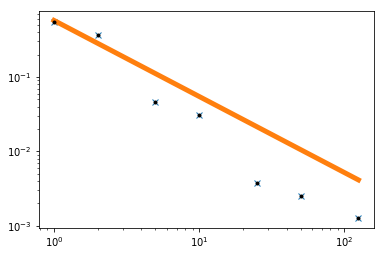

In [52]:
degree_sequence = [d for (n, d) in g.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
tot = sum(cnt)
per = [c / tot for c in cnt]

ts = sorted([(deg[i], per[i]) for i in range(len(per))])
deg = [t[0] for t in ts]
per = [t[1] for t in ts]

def deg_curve(lb, gamma, a):
    return a * lb**-gamma

x = deg[6:]
x = deg
y = per[6:]
y = per

print(len(x))

popt = curve_fit(deg_curve, x, y)[0]
print(popt)
gamma = popt[0]

plt.xscale('log')
plt.yscale('log')
plt.plot(deg, per, 'x')
xx = np.linspace(min(deg), max(deg), 100)
yy = [deg_curve(x, *popt) for x in xx]
plt.plot(xx, yy, lw=5)
plt.plot(x, y, '.', c='black')
plt.show()


In [53]:
def deg_plot(G):

    degree_sequence = [d for (n, d) in G.degree()]
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    tot = sum(cnt)
    per = [c / tot for c in cnt]

    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(deg, per)
    plt.show()

length scale:  1 num nodes:  1572 num edges:  1728
======== [0.06574612] ========


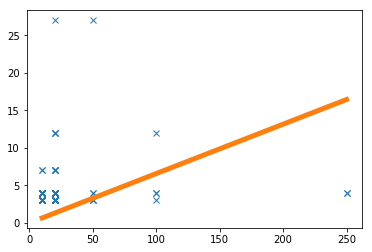

length scale:  2 num nodes:  1572 num edges:  1728
======== [0.06998054] ========


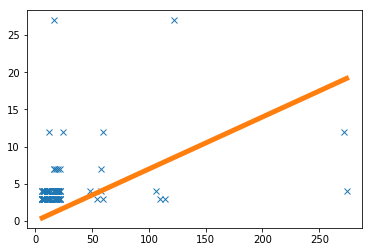

length scale:  3 num nodes:  1572 num edges:  1728
======== [0.0689524] ========


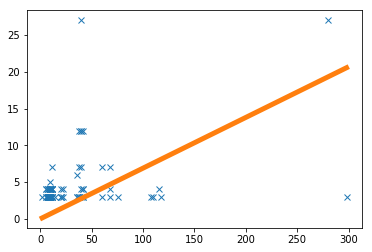

length scale:  4 num nodes:  1572 num edges:  1728
======== [0.01041667] ========


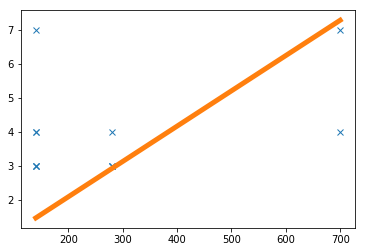

length scale:  5 num nodes:  1572 num edges:  1728
======== [0.00989742] ========


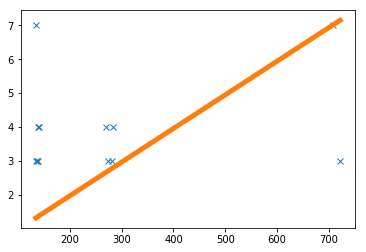

length scale:  6 num nodes:  1572 num edges:  1728
======== [0.01044441] ========


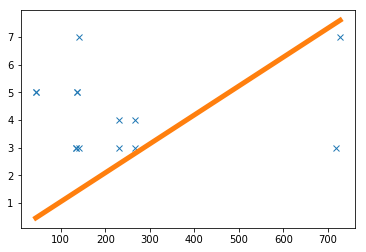

length scale:  7 num nodes:  1572 num edges:  1728
======== [0.01036675] ========


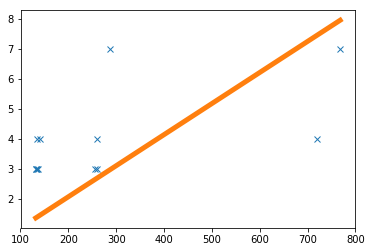

length scale:  8 num nodes:  1572 num edges:  1728
======== [0.00897829] ========


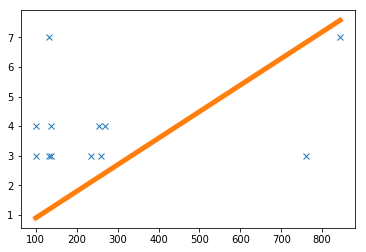

length scale:  9 num nodes:  1572 num edges:  1728
======== [0.00893275] ========


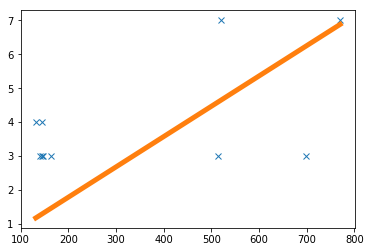

length scale:  10 num nodes:  1572 num edges:  1728
======== [0.00756608] ========


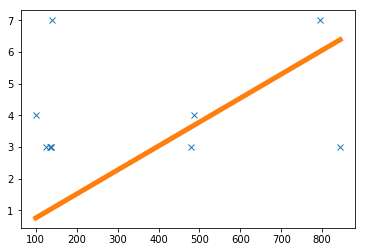

length scale:  11 num nodes:  1572 num edges:  1728
======== [0.00817247] ========


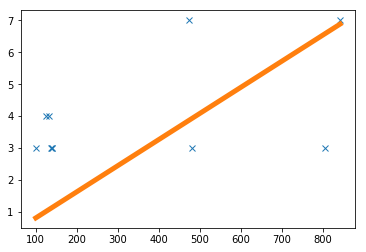

length scale:  12 num nodes:  1572 num edges:  1728
======== [0.00598052] ========


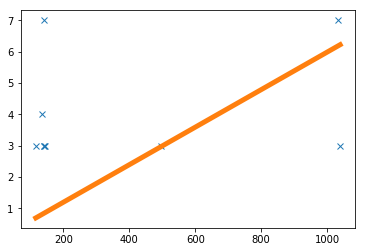

length scale:  13 num nodes:  1572 num edges:  1728
======== [0.00174419] ========


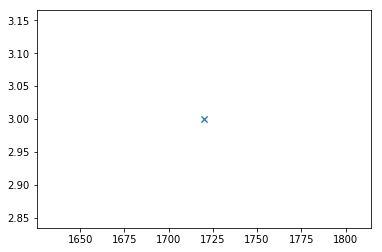

length scale:  14 num nodes:  1572 num edges:  1728
======== [0.00174418] ========


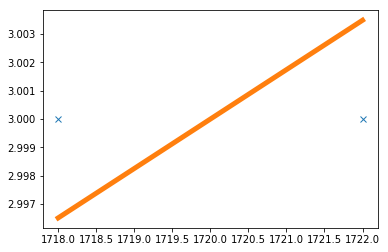

length scale:  15 num nodes:  1572 num edges:  1728
======== [0.00174413] ========


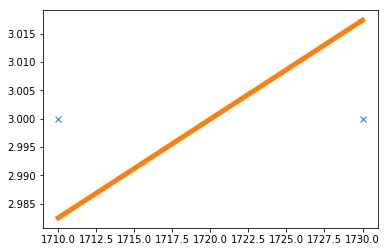

length scale:  16 num nodes:  1572 num edges:  1728
======== [0.00174358] ========


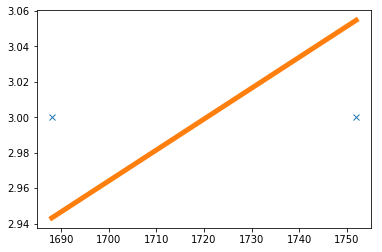

length scale:  17 num nodes:  1572 num edges:  1728
======== [0.00174283] ========


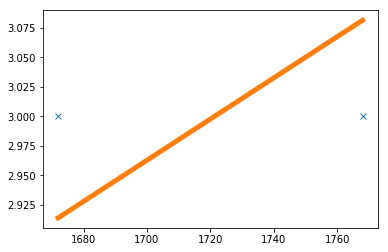

length scale:  18 num nodes:  1572 num edges:  1728
======== [0.00310307] ========


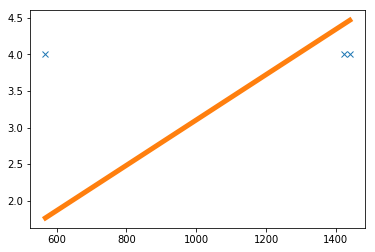

In [54]:
# ref = fractal_model(5,2,2,0)
ref = g
sbs = []

def scaler(x, y):
    return y * x

for l in tqdm_notebook(np.arange(1, max_l - 1)):
#     g = nx.read_graphml('time_graphs/0/4990.graphml')
    ref = g
    print("length scale: ", l, "num nodes: ", ref.number_of_nodes(), "num edges: ", ref.number_of_edges())
    boxes_subgraphs = list(subgraphs[l].values())
#     ks = [sorted(box.degree, key=lambda x: x[1], reverse=True)[0][1] for box in boxes_subgraphs]
    ks = [box.number_of_edges() / 0.5 for box in boxes_subgraphs]
    node_dict = {}
    for idx, box in enumerate(boxes_subgraphs):
        for node in box.nodes:
            node_dict[node] = str(idx)
    edges = []
    for edge in ref.edges:
        edges.append(tuple(sorted([node_dict[edge[0]], node_dict[edge[1]]])))

    edges = list(set(edges))
    ref = nx.Graph()
    ref.add_edges_from(edges)
    k_primes = ref.degree()
    k_primes = [k[1] for k in k_primes]

    vals = [(ks[i], k_primes[i]) for i in range(len(ks))]
    vals = sorted(vals)
    ks = [v[0] for v in vals]
    k_primes = [v[1] for v in vals]
    
    popt = curve_fit(scaler, ks, k_primes)[0]
    print("========", popt, "========")
    sbs.append(popt)

    plt.plot(ks, k_primes, 'x')
    xx = np.linspace(ks[0], ks[-1], 100)
    yy = [scaler(x, popt) for x in xx]
    plt.plot(xx, yy, lw=5)
    
    plt.show()

[3.46485396]


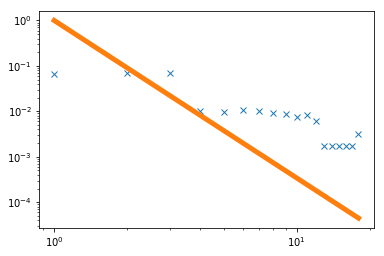

In [55]:
def deg_curve(lb, gamma):
    return lb**-gamma

x = np.arange(1, len(sbs) + 1)
y = [s[0] for s in sbs]

popt = curve_fit(deg_curve, x, y)[0]
print(popt)
dk = popt[0]

plt.xscale('log')
plt.yscale('log')
plt.plot(x, y, 'x')
xx = np.linspace(x[0], x[-1], 100)
yy = [deg_curve(x, popt) for x in xx]
plt.plot(xx, yy, lw=5)
plt.show()

In [56]:
1 + db / dk

1.8788136895572412

In [57]:
gamma

1.0213351270518727

(array([ 2.58096879, 37.48177743]), array([[1.78691089e-02, 1.99120086e+00],
       [1.99120086e+00, 2.23051891e+02]]))


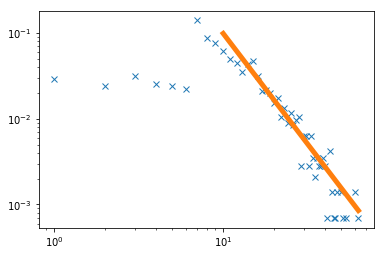

0.9465556387090662


In [32]:
# def scale(lb, a, b):
#     return  b * lb**-a

# G = nx.read_graphml('time_graphs/0/2000.graphml')
# g = G

# degree_sequence = [d for (n, d) in G.degree()]
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# tot = sum(cnt)
# per = [c / tot for c in cnt]

# vals = sorted([(deg[i], per[i]) for i in range(len(deg))])
# x = np.array([v[0] for v in vals])[15:]
# y = np.array([v[1] for v in vals])[15:]

# popt = curve_fit(scale, x, y)
# print(popt)
# popt = popt[0]

# plt.xscale('log')
# plt.yscale('log')
# plt.plot(deg, per, 'x')
# xx = np.linspace(10, max(x), 100)
# yy = [scale(x, *popt) for x in xx]
# plt.plot(xx, yy, lw=5)
# plt.show()

# y_fit = scale(x, *popt)

# ss_res = np.sum((y - y_fit) ** 2)

# # total sum of squares
# ss_tot = np.sum((y - np.mean(y)) ** 2)

# # r-squared
# r2 = 1 - (ss_res / ss_tot)

# print(r2)

old:  1441 9125
length scale:  1 num nodes:  1441 num edges:  9125
new:  195 2039
(array([0.54594408, 0.10439503]), array([[0.018084  , 0.00555277],
       [0.00555277, 0.00176615]]))


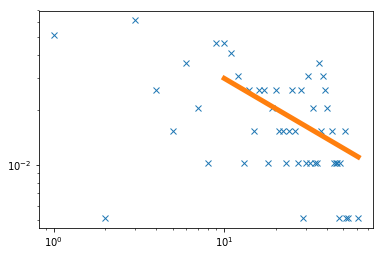

0.2788312683613554
old:  1441 9125
length scale:  2 num nodes:  1441 num edges:  9125
new:  50 484
(array([-0.13493342,  0.02717387]), array([[0.08770249, 0.00734684],
       [0.00734684, 0.0006255 ]]))


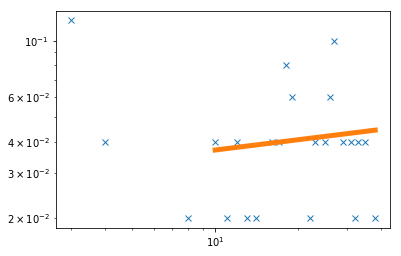

0.013580435037106708
old:  1441 9125
length scale:  3 num nodes:  1441 num edges:  9125
new:  19 124
(array([-1.24570892,  0.00444418]), array([[1.42254029e+00, 1.71972565e-02],
       [1.71972565e-02, 2.08766460e-04]]))


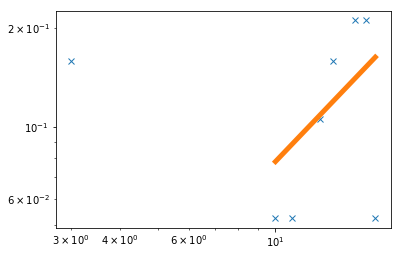

0.24379409421207843
old:  1441 9125
length scale:  4 num nodes:  1441 num edges:  9125
new:  8 21
(array([0.7910205, 0.9408603]), array([[0.32172502, 0.44329376],
       [0.44329376, 0.65971754]]))


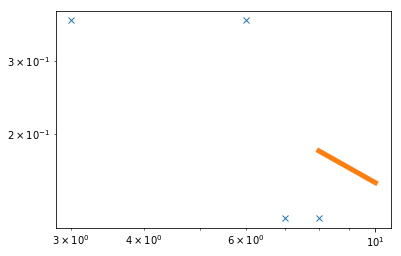

0.5024804053019355
old:  1441 9125
length scale:  5 num nodes:  1441 num edges:  9125
new:  4 10



TypeError: Improper input: N=2 must not exceed M=1

In [38]:
# for l in tqdm_notebook(np.arange(1, 6)):
#     ref = g
#     print("old: ", ref.number_of_nodes(), ref.number_of_edges())
#     print("length scale: ", l, "num nodes: ", ref.number_of_nodes(), "num edges: ", ref.number_of_edges())
#     boxes_subgraphs = list(subgraphs[l].values())
# #     ks = [sorted(box.degree, key=lambda x: x[1], reverse=True)[0][1] for box in boxes_subgraphs]
#     ks = [box.number_of_edges() / 0.5 for box in boxes_subgraphs]
#     node_dict = {}
#     for idx, box in enumerate(boxes_subgraphs):
#         for node in box.nodes:
#             node_dict[node] = str(idx)
#     edges = []
#     for edge in ref.edges:
#         edges.append(tuple(sorted([node_dict[edge[0]], node_dict[edge[1]]])))

#     edges = list(set(edges))
#     ref = nx.Graph()
#     ref.add_edges_from(edges)
#     G = ref
#     print("new: ", ref.number_of_nodes(), ref.number_of_edges())

#     degree_sequence = [d for (n, d) in G.degree()]
#     degreeCount = collections.Counter(degree_sequence)
#     deg, cnt = zip(*degreeCount.items())

#     tot = sum(cnt)
#     per = [c / tot for c in cnt]

#     vals = sorted([(deg[i], per[i]) for i in range(len(deg))])
#     x = np.array([v[0] for v in vals])[int(len(vals) * .15):]
#     y = np.array([v[1] for v in vals])[int(len(vals) * .15):]

#     popt = curve_fit(scale, x, y)
#     print(popt)
#     popt = popt[0]

#     plt.xscale('log')
#     plt.yscale('log')
#     plt.plot(deg, per, 'x')
#     xx = np.linspace(10, max(x), 100)
#     yy = [scale(x, *popt) for x in xx]
#     plt.plot(xx, yy, lw=5)

#     plt.savefig('deg_plots/' + str(idx) + '.png')

#     plt.show()
    
#     y_fit = scale(x, *popt)

#     ss_res = np.sum((y - y_fit) ** 2)

#     # total sum of squares
#     ss_tot = np.sum((y - np.mean(y)) ** 2)

#     # r-squared
#     r2 = 1 - (ss_res / ss_tot)
#     print(r2)